#### This file cleaned the abstract data, and conducted feature engeneering using TF-IDF model, PCA and topic models.
#### Then I calculated the distance between each patent and its citations.

In [1]:
import pandas as pd 
import numpy as np
import copy 
import random
from matplotlib import pyplot as plt 
from glob import glob
from datetime import datetime
import re
import nltk
from numpy.linalg import norm
from scipy.spatial.distance import pdist
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stop = stopwords.words('english')
from nltk import pos_tag
import seaborn as sns; sns.set()

In [2]:
# spefcify the path
path = '/Users/philhuang/Desktop/Phil_projects/Patent-main/workdata/'

In [3]:
# read in data
pooling_patent_data = pd.read_csv(path+'pooling_patent_data.csv')
pooling_patent_data

,Patent_ID,Patent_abstract
0,CN98118142.2,A Chinese patent medicine in the form of capsu...
1,CN200710126165.3,The invention discloses a method and apparatus...
2,CN200610060717.0,The method comprises: receiving an audio signa...
3,CN00103340.9,A device for eliminating the mini ice crystal ...
4,CN200710075612.7,The invention provides a method of producing s...
...,...,...
263667,JPH0217849,PURPOSE: To facilitate stopping rotation of a ...
263668,WO2005017670A,"An embodiment of the invention, for controllin..."
263669,DE202005008280U,A radial fan (20) has an impeller (22) enclose...
263670,KR100211453B,AbstractTranslated from Korean The remote cont...


In [4]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Apply stemming and remove punctuation, digits, and non-English words
stemmer = PorterStemmer()

def clean_and_stem_nouns_verbs(sentence):
    # Remove punctuation and digits
    clean_sentence = re.sub(r'[^\w\s]', ' ', sentence)
    clean_sentence = re.sub(r'\d+', '', clean_sentence)
    
    # Tokenize the sentence
    tokens = word_tokenize(clean_sentence)
    
    # POS tagging and filtering nouns (NN) and verbs (VB)
    pos_tags = pos_tag(tokens)
    filtered_tokens = [token for token, pos in pos_tags if pos.startswith('NN') or pos.startswith('VB')]
    
    # Stem and filter non-English words
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens if token.isalpha() and token.isascii()]
    
    return ' '.join(stemmed_tokens)

[nltk_data] Downloading package punkt to /Users/philhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/philhuang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
# apply the function to the data
start_time = datetime.now()
pooling_patent_data['cleaned_and_stemmed_nouns_verbs_abstract'] = pooling_patent_data['Patent_abstract'].astype(str).apply(clean_and_stem_nouns_verbs)
end_time = datetime.now()

pooling_patent_data.to_csv(path+'pooling_patent_data_filter.csv', index= False)

In [7]:
# track the time
print('Time cost: {0}'.format(end_time-start_time))

Time cost: 0:24:20.387266


In [9]:
# check the data
pooling_patent_data

,Patent_ID,Patent_abstract,cleaned_and_stemmed_nouns_verbs_abstract
0,CN98118142.2,A Chinese patent medicine in the form of capsu...,patent medicin form capsul is prepar chiretta ...
1,CN200710126165.3,The invention discloses a method and apparatus...,invent disclos method apparatu hide data packa...
2,CN200610060717.0,The method comprises: receiving an audio signa...,method compris receiv signal signal sourc get ...
3,CN00103340.9,A device for eliminating the mini ice crystal ...,devic elimin mini ice crystal supercool water ...
4,CN200710075612.7,The invention provides a method of producing s...,invent provid method produc effect calcul part...
...,...,...,...
263667,JPH0217849,PURPOSE: To facilitate stopping rotation of a ...,purpos facilit stop rotat rotor open hole posi...
263668,WO2005017670A,"An embodiment of the invention, for controllin...",embodi invent control context menu use web pag...
263669,DE202005008280U,A radial fan (20) has an impeller (22) enclose...,fan ha impel enclos case air inlet air inlet o...
263670,KR100211453B,AbstractTranslated from Korean The remote cont...,abstracttransl korean control lock unlock devi...


In [18]:
#pooling_patent_data=pd.read_csv(path+'pooling_patent_data_filter.csv')

### TFIDF_table

In [14]:
# Create a TfidfVectorizer instance with the specified parameters
##tfidf_table:  max_df=0.95, min_df=2: 38.44G with 50,000 cols
##tfidf_table_filter:  max_df=0.95, min_df = 0.001: 2G with 2605 cols(this one)
##tfidf_table_filter:  max_df=0.95, min_df = 0.005: 7M with 100 cols

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=0.001)

# Fit and transform the 'cleaned_and_stemmed_nouns_verbs_abstract' column into a TF-IDF matrix
start_time   = datetime.now()
tfidf_matrix = vectorizer.fit_transform(pooling_patent_data['cleaned_and_stemmed_nouns_verbs_abstract'])
end_time     = datetime.now()
print('Time cost: {0}'.format(end_time-start_time))

Time cost: 0:00:10.548390


In [15]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_table = pd.DataFrame(tfidf_matrix.toarray(), index=pooling_patent_data['Patent_ID'], columns=vectorizer.get_feature_names_out())
tfidf_table

,aaa,ab,abil,abnorm,abov,abras,absenc,absorb,absorpt,abstract,...,yield,yoke,zero,zinc,zirconium,zn,zno,zone,zoom,zr
Patent_ID,,,,,,,,,,,,,,,,,,,,,
CN98118142.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN200710126165.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN200610060717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN00103340.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN200710075612.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JPH0217849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WO2005017670A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DE202005008280U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074043,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# output the data
tfidf_table.to_csv(path+'tfidf_table_filter.csv', index= True)

### PCA analysis

In [6]:
from sklearn.decomposition import PCA

# Number of principal components to keep
n_components = 30

# Fit PCA to the tfidf_table
pca      = PCA(n_components=n_components)
pca_data = pca.fit_transform(tfidf_table)

In [7]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.01344012, 0.00860788, 0.00693339, 0.00664208, 0.0059799 ,
       0.00542903, 0.00503322, 0.00481055, 0.00455948, 0.00431732,
       0.00422998, 0.00409882, 0.00398773, 0.00390085, 0.0038233 ,
       0.00362672, 0.00355732, 0.00350455, 0.00336971, 0.00335648,
       0.00330424, 0.00323844, 0.00315914, 0.00303027, 0.00300911,
       0.00295419, 0.00286327, 0.00280325, 0.00276814, 0.00275806])

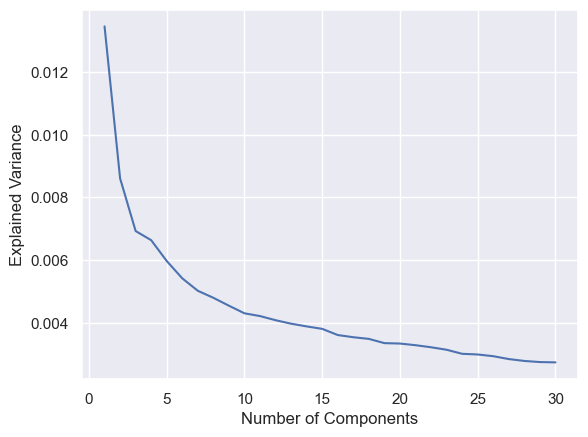

In [8]:
# check how much the PCA component explains the data
plt.plot(range(1, n_components+1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [9]:
# Convert the PCA data to a DataFrame
pca_columns = [f'PCA{i}' for i in range(1, n_components + 1)]
pca_table = pd.DataFrame(pca_data, index=tfidf_table.index, columns=pca_columns)
pca_table.to_csv(path+'pca_table.csv', index= True)
pca_table

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
Patent_ID,,,,,,,,,,,,,,,,,,,,,
CN98118142.2,-0.108737,-0.115023,-0.140613,-0.132428,-0.036515,-0.032047,-0.011306,-0.005437,-0.057770,-0.032796,...,0.034437,-0.036567,0.002970,0.023725,0.041142,-0.005990,0.055797,0.121554,-0.075801,-0.140499
CN200710126165.3,0.090840,0.012887,-0.084785,-0.003381,0.242783,-0.005561,-0.090873,0.115954,-0.103936,0.044932,...,-0.019476,-0.017095,-0.018048,0.061192,0.029018,-0.035142,0.098224,-0.019941,-0.025305,0.072369
CN200610060717.0,0.045865,0.092287,-0.100176,-0.045865,0.009804,0.040426,0.050847,-0.032226,0.009589,-0.007232,...,-0.055110,0.039449,0.047177,0.013128,-0.014547,0.019790,0.002512,-0.059228,0.027994,0.000854
CN00103340.9,-0.114467,0.004734,0.086242,-0.086429,-0.007396,-0.006122,-0.088881,0.021173,0.048591,0.013054,...,0.047840,0.021224,-0.014059,-0.026821,0.061447,0.000242,0.020117,0.029257,-0.027677,0.021042
CN200710075612.7,0.036705,0.141772,-0.065560,-0.032380,-0.025679,0.092314,0.042887,-0.051232,-0.027857,-0.055329,...,-0.068869,0.050866,0.052462,-0.010802,-0.006709,0.054162,-0.023497,0.092959,-0.025565,-0.104490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JPH0217849,-0.132939,0.042464,0.218795,0.012120,0.068667,0.046677,0.053788,0.010947,-0.110873,0.018226,...,-0.042814,-0.013515,-0.007335,0.054846,0.017838,0.031437,0.011711,0.001351,-0.024894,0.024314
WO2005017670A,0.022948,-0.030275,-0.009890,-0.012198,0.005022,-0.019626,0.055230,-0.031444,0.021228,0.012404,...,-0.007899,0.010885,0.039883,0.010471,-0.065783,-0.049739,-0.026319,0.001056,-0.009877,-0.001729
DE202005008280U,-0.121231,0.131232,0.125267,-0.058773,-0.057073,0.039160,-0.128961,0.050040,0.140781,0.056648,...,0.061225,0.036720,-0.026536,-0.108961,-0.040442,-0.168091,0.172418,-0.013734,-0.027691,0.024063


In [10]:
#pd.read_csv(path+'pca_table.csv').set_index('Patent_ID')

### 2) LDA: Topic Model

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA to the tfidf_table
lda = LatentDirichletAllocation(n_components=30)
lda.fit(tfidf_table)

# Transform the tfidf_table to topic distribution
topic_distribution = lda.transform(tfidf_table)

# Create a DataFrame with Patent_ID and topic distributions
topic_distribution_df = pd.DataFrame(topic_distribution, columns=[f'topic_{i}' for i in range(topic_distribution.shape[1])])

topic_distribution_df['Patent_ID'] = pooling_patent_data.reset_index()['Patent_ID']
topic_distribution_df = topic_distribution_df.reset_index(drop=True).set_index('Patent_ID')
topic_distribution_df.to_csv(path+'lda_table.csv', index= True)
topic_distribution_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
Patent_ID,,,,,,,,,,,,,,,,,,,,,
CN98118142.2,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,...,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855,0.005855
CN200710126165.3,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,...,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100,0.006100
CN200610060717.0,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,...,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345,0.007345
CN00103340.9,0.006189,0.006189,0.006189,0.006189,0.006189,0.006189,0.006189,0.006189,0.006189,0.006189,...,0.006189,0.006189,0.820532,0.006189,0.006189,0.006189,0.006189,0.006189,0.006189,0.006189
CN200710075612.7,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,...,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773,0.005773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JPH0217849,0.005522,0.005522,0.005522,0.005522,0.005522,0.005522,0.005522,0.005522,0.005522,0.005522,...,0.005522,0.005522,0.005522,0.005522,0.005522,0.839876,0.005522,0.005522,0.005522,0.005522
WO2005017670A,0.008319,0.008319,0.008319,0.008319,0.008319,0.758751,0.008319,0.008319,0.008319,0.008319,...,0.008319,0.008319,0.008319,0.008319,0.008319,0.008319,0.008319,0.008319,0.008319,0.008319
DE202005008280U,0.006775,0.006775,0.006775,0.006775,0.006775,0.006775,0.633111,0.006775,0.006775,0.006775,...,0.006775,0.006775,0.006775,0.006775,0.006775,0.006775,0.006775,0.006775,0.006775,0.006775


In [12]:
# pd.read_csv(path+'lda_table.csv').set_index('Patent_ID')

In [13]:
# Display the top words for each topic
n_top_words = 10

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([tfidf_table.columns[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print("\n")

Topic #1:
messag servic network user inform telephon termin subscrib number commun


Topic #2:
light heat radiat plate emit surfac led sourc lamp fin


Topic #3:
address packet network messag ip router data port rout multicast


Topic #4:
media network gateway servic session protocol stream server data commun


Topic #5:
door vehicl model util box cabl bodi car control devic


Topic #6:
imag display video data signal pictur color pixel screen devic


Topic #7:
air valv pressur fan control temperatur compressor motor chamber refriger


Topic #8:
data interfac control modul memori card bu unit signal circuit


Topic #9:
network node path link rout commun servic connect switch inform


Topic #10:
len beam laser imag measur surfac light camera posit axi


Topic #11:
key charact keyboard input encrypt devic display gp control user


Topic #12:
prepar medicin extract root invent treat composit materi diseas effect


Topic #13:
member portion hous bodi connector end cover contact mount posit


### 3) Word Embedding: vector space 

In [20]:
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(sentence, min_df=0.005, max_df=0.9):
    clean_sentence = re.sub(r'[^\w\s]', ' ', sentence)
    clean_sentence = re.sub(r'\d+', '', clean_sentence)
    tokens = word_tokenize(clean_sentence)
    lower_tokens = [token.lower() for token in tokens if token.isalpha() and token.isascii() and token.lower() not in stop_words]

    # Filter out words that are too frequent or too rare
    token_counts = Counter(lower_tokens)
    filtered_tokens = [token for token, count in token_counts.items() if count/ len(lower_tokens) >= min_df and count / len(lower_tokens) <= max_df]

    return filtered_tokens

# tokenize and clean the abstract
pooling_patent_data['filtered_tokenized_abstract'] = pooling_patent_data['cleaned_and_stemmed_nouns_verbs_abstract'].astype(str).apply(tokenize_and_filter)

def average_word_embedding(tokens, model, vector_size):
    embeddings = [model.wv[token] for token in tokens if token in model.wv.key_to_index]
    if len(embeddings) == 0:
        return np.zeros(vector_size)
    return np.mean(embeddings, axis=0)

# Train a Word2Vec model on the filtered tokenized abstracts
word2vec_model = Word2Vec(sentences=pooling_patent_data['filtered_tokenized_abstract'], vector_size=100, window=5, min_count=1, workers=4)

# Save the trained Word2Vec model
word2vec_model.save(path+'word2vec_model_filtered.model')

# Compute the average word embeddings for each filtered abstract
pooling_patent_data['avg_word_embedding_filtered'] = pooling_patent_data['filtered_tokenized_abstract'].apply(lambda x: average_word_embedding(x, word2vec_model, 100))
avg_word_embedding_filtered = pooling_patent_data[['Patent_ID','avg_word_embedding_filtered']]

avg_word_embedding_filtered.to_csv(path+'wbed_table.csv', index= False)

# Create a new DataFrame from the lists
expanded_df = pd.DataFrame(avg_word_embedding_filtered['avg_word_embedding_filtered'].tolist())

# Set the index of the expanded_df to be the same as the index of avg_word_embedding_filtered
expanded_df.index = avg_word_embedding_filtered.index

# Rename the columns of the new DataFrame as 'Vec1', 'Vec2', etc.
expanded_df.columns = [f'Vec{i+1}' for i in range(expanded_df.shape[1])]

# Drop the 'avg_word_embedding_filtered' column from the original DataFrame
avg_word_embedding_filtered = avg_word_embedding_filtered.drop('avg_word_embedding_filtered', axis=1)

# Concatenate the original DataFrame with the new DataFrame along the columns axis
wbed_table = pd.concat([avg_word_embedding_filtered, expanded_df], axis=1)
wbed_table.index.name = 'Patent_ID'
wbed_table.to_csv(path+'wbed_table.csv', index= False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Calculate Distance

In [97]:
def get_distance(pair, table, distance_type):
    patent1_id = pair['APPLN_ID_SIPO']
    patent2_id = pair['PubNum_google']

    if patent1_id not in table.index or patent2_id not in table.index:
        return float('inf')  # Return a large distance value if either key is missing
    
    patent1_features = table.loc[patent1_id].values
    patent2_features = table.loc[patent2_id].values


    if distance_type == 'euclidean':
        return euclidean(patent1_features, patent2_features)
    elif distance_type == 'cosine':
        return cosine(patent1_features, patent2_features)
    elif distance_type == 'jensenshannon':
        return jensenshannon(patent1_features, patent2_features)
    else:
        raise ValueError(f"Unsupported distance type: {distance_type}")

In [3]:
# read in the data we need to calculate the distance of the patents
pca_table   = pd.read_csv(path+'pca_table.csv').set_index('Patent_ID')
wbed_table  = pd.read_csv(path+'wbed_table.csv').set_index('Patent_ID')
lda_table   = pd.read_csv(path+'lda_table.csv').set_index('Patent_ID')
tfidf_table = pd.read_csv(path+'tfidf_table_filter.csv').set_index('Patent_ID')
PAIRS       = pd.read_csv(path+'pairs.csv')

In [99]:
from scipy.spatial.distance import euclidean, cosine, jensenshannon

distance_df = pd.DataFrame(columns=['APPLN_ID_SIPO', 'PubNum_google', 
                                    'distance_lda_euclidean', 'distance_lda_cosine', 'distance_lda_jensenshannon',
                                    'distance_pca_euclidean', 'distance_pca_cosine', 'distance_pca_jensenshannon',
                                    'distance_wbed_euclidean', 'distance_wbed_cosine', 'distance_wbed_jensenshannon'])

start_time = datetime.now()
for _, pair in PAIRS2.iterrows():
    tables = [lda_table, pca_table, wbed_table]
    distances = ['euclidean', 'cosine', 'jensenshannon']
    results = {}

    for table_name, table in zip(['lda', 'pca', 'wbed'], tables):
        for distance_type in distances:
            distance = get_distance(pair, table, distance_type)
            results[f'distance_{table_name}_{distance_type}'] = distance

    result_row = pd.DataFrame({
        'APPLN_ID_SIPO': [pair['APPLN_ID_SIPO']],
        'PubNum_google': [pair['PubNum_google']],
        **results
    })

    distance_df = pd.concat([distance_df, result_row], ignore_index=True)
    
end_time = datetime.now()

/Users/philhuang/opt/anaconda3/envs/py3k/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/philhuang/opt/anaconda3/envs/py3k/lib/python3.9/site-packages/scipy/spatial/distance.py:1249: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


In [113]:
# distance_df.to_csv(path+'distance_df.csv', index=False)

In [114]:
distance_df = pd.read_csv(path+'distance_df.csv')
distance_df

,APPLN_ID_SIPO,PubNum_google,distance_lda_euclidean,distance_lda_cosine,distance_lda_jensenshannon,distance_pca_euclidean,distance_pca_cosine,distance_pca_jensenshannon,distance_wbed_euclidean,distance_wbed_cosine,distance_wbed_jensenshannon
0,CN200710048659.4,CN100390228C,1.100083,0.978693,0.712483,0.168275,0.422944,inf,3.955420,0.268455,inf
1,CN200710048659.4,CN1145295A,1.103813,0.979040,0.714020,0.066401,0.085952,inf,3.628576,0.222297,inf
2,CN200710048659.4,CN1250621C,1.128510,0.981211,0.724644,0.103162,0.124839,inf,4.507649,0.378274,inf
3,CN200610049754.1,CN2137383Y,1.040743,0.980066,0.730735,0.378972,1.219377,inf,3.887276,0.284544,inf
4,CN200610139796.4,US7183927B2,0.813676,0.939379,0.626846,1.033347,0.973323,inf,6.572389,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
304309,CN200610017899.3,CN1560297A,1.156532,0.983707,0.734968,0.132916,0.186457,inf,2.084979,0.058128,inf
304310,CN200610017899.3,JPH04230905A,0.024762,0.000472,0.068197,0.057415,0.045540,inf,2.615358,0.094122,inf
304311,CN200610017899.3,JP2000057850A,0.411587,0.135999,0.334230,0.096600,0.134202,inf,2.801421,0.117309,inf
304312,CN200610017899.3,JPS59208770A,0.463181,0.178427,0.354487,0.161013,0.372244,inf,3.771404,0.224701,inf


In [5]:
#### If time permits, do some distance calculations based on TFIDF, then we can use jaccard:
from scipy.spatial.distance import euclidean, cosine, jensenshannon, jaccard
def binarize_features(features, threshold=0):
    return (features > threshold).astype(int)

### Get DIST using TFIDF:
def get_distance_tfidf(pair, tfidf_table, distance_type):
    patent1_id = pair['APPLN_ID_SIPO']
    patent2_id = pair['PubNum_google']
    
    if patent1_id not in tfidf_table.index or patent2_id not in tfidf_table.index:
        return float('inf')  # Return a large distance value if either key is missing
    
    patent1_features = tfidf_table.loc[patent1_id].values
    patent2_features = tfidf_table.loc[patent2_id].values

    if distance_type == 'euclidean':
        return euclidean(patent1_features, patent2_features)
    elif distance_type == 'cosine':
        return cosine(patent1_features, patent2_features)
    elif distance_type == 'jensenshannon':
        return jensenshannon(patent1_features, patent2_features) 
    elif distance_type == 'jaccard':
        patent1_binary_features = binarize_features(patent1_features)
        patent2_binary_features = binarize_features(patent2_features)
        return jaccard(patent1_binary_features, patent2_binary_features)
    else:
        raise ValueError(f"Unsupported distance type: {distance_type}")

        
distance_tfidf_df = pd.DataFrame(columns=['APPLN_ID_SIPO', 'PubNum_google', 
                                    'distance_tfidf_euclidean', 'distance_tfidf_cosine', 
                                    'distance_tfidf_jensenshannon', 'distance_tfidf_jaccard'])


for i, pair in PAIRS.iterrows():
    distance_tfidf_euclidean = get_distance_tfidf(pair, tfidf_table, distance_type='euclidean')
    distance_tfidf_cosine = get_distance_tfidf(pair, tfidf_table, distance_type='cosine')
    distance_tfidf_jensenshannon = get_distance_tfidf(pair, tfidf_table, distance_type='jensenshannon')
    distance_tfidf_jaccard = get_distance_tfidf(pair, tfidf_table, distance_type='jaccard')
   

    result_row = pd.DataFrame({
        'APPLN_ID_SIPO': [pair['APPLN_ID_SIPO']],
        'PubNum_google': [pair['PubNum_google']],
        'distance_tfidf_euclidean': [distance_tfidf_euclidean],
        'distance_tfidf_cosine': [distance_tfidf_cosine],
        'distance_tfidf_jensenshannon': [distance_tfidf_jensenshannon],
        'distance_tfidf_jaccard': [distance_tfidf_jaccard]
    })
    
    if i%1000 == 0:
        print('We are at row {0} now.'.format(i))

    distance_tfidf_df = pd.concat([distance_tfidf_df, result_row], ignore_index=True)

We are at row 0 now.
We are at row 1000 now.
We are at row 2000 now.
We are at row 3000 now.
We are at row 4000 now.
We are at row 5000 now.
We are at row 6000 now.
We are at row 7000 now.
We are at row 8000 now.
We are at row 9000 now.
We are at row 10000 now.
We are at row 11000 now.
We are at row 12000 now.
We are at row 13000 now.
We are at row 14000 now.
We are at row 15000 now.
We are at row 16000 now.
We are at row 17000 now.
We are at row 18000 now.
We are at row 19000 now.
We are at row 20000 now.
We are at row 21000 now.
We are at row 22000 now.
We are at row 23000 now.
We are at row 24000 now.
We are at row 25000 now.
We are at row 26000 now.
We are at row 27000 now.
We are at row 28000 now.
We are at row 29000 now.
We are at row 30000 now.
We are at row 31000 now.
We are at row 32000 now.
We are at row 33000 now.
We are at row 34000 now.
We are at row 35000 now.
We are at row 36000 now.
We are at row 37000 now.
We are at row 38000 now.
We are at row 39000 now.
We are at row

In [8]:
# save the data
distance_tfidf_df.to_csv(path+'distance_tfidf_df.csv', index= False)
distance_tfidf_df

,APPLN_ID_SIPO,PubNum_google,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
0,CN200710048659.4,CN100390228C,1.272701,0.809884,0.755645,0.911111
1,CN200710048659.4,CN1145295A,1.071938,0.574525,0.692075,0.875000
2,CN200710048659.4,CN1250621C,1.207117,0.728565,0.744464,0.935484
3,CN200610049754.1,CN2137383Y,1.414214,1.000000,0.832555,1.000000
4,CN200610139796.4,US7183927B2,1.414214,1.000000,0.832555,1.000000
...,...,...,...,...,...,...
304309,CN200610017899.3,CN1560297A,1.235618,0.763376,0.679537,0.754386
304310,CN200610017899.3,JPH04230905A,1.107978,0.613808,0.663671,0.830189
304311,CN200610017899.3,JP2000057850A,1.233610,0.760897,0.725643,0.882353
304312,CN200610017899.3,JPS59208770A,0.985018,0.485131,0.676689,0.915493


In [11]:
# check the summary statistics of the data
test = distance_tfidf_df[distance_tfidf_df['distance_tfidf_euclidean']!=np.inf]
test

,APPLN_ID_SIPO,PubNum_google,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
0,CN200710048659.4,CN100390228C,1.272701,0.809884,0.755645,0.911111
1,CN200710048659.4,CN1145295A,1.071938,0.574525,0.692075,0.875000
2,CN200710048659.4,CN1250621C,1.207117,0.728565,0.744464,0.935484
3,CN200610049754.1,CN2137383Y,1.414214,1.000000,0.832555,1.000000
4,CN200610139796.4,US7183927B2,1.414214,1.000000,0.832555,1.000000
...,...,...,...,...,...,...
304309,CN200610017899.3,CN1560297A,1.235618,0.763376,0.679537,0.754386
304310,CN200610017899.3,JPH04230905A,1.107978,0.613808,0.663671,0.830189
304311,CN200610017899.3,JP2000057850A,1.233610,0.760897,0.725643,0.882353
304312,CN200610017899.3,JPS59208770A,0.985018,0.485131,0.676689,0.915493


In [12]:
test.describe()

,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
count,262954.000000,262954.000000,262954.000000,262954.000000
mean,1.248763,0.794298,0.740520,0.886133
std,0.170839,0.179748,0.079678,0.093119
min,0.000000,0.000000,0.000000,0.000000
25%,1.180174,0.696406,0.709284,0.854167
50%,1.291944,0.834559,0.750506,0.896552
75%,1.368809,0.936820,0.788197,0.935484
max,1.414214,1.000000,0.832555,1.000000


In [13]:
distance_tfidf_df[distance_tfidf_df['distance_tfidf_euclidean']==0]

,APPLN_ID_SIPO,PubNum_google,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
1856,CN200610045576.5,CN1888023A,0.0,0.0,0.0,0.0
2246,CN200510121093.4,CN1822205A,0.0,0.0,0.0,0.0
2250,CN200510121099.1,CN1822195A,0.0,0.0,0.0,0.0
6161,CN200710074301.9,CN101104621A,0.0,0.0,0.0,0.0
6846,CN200710028038.X,CN100590579C,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
201990,CN200610113684.1,CN100390066C,0.0,0.0,0.0,0.0
202101,CN200710178240.0,CN100584461C,0.0,0.0,0.0,0.0
207463,CN200510026293.1,CN1873037A,0.0,0.0,0.0,0.0
241989,CN200710163103.X,CN101193068A,0.0,0.0,0.0,0.0


I do find that some patents are almost the same with what they have cited. Let's check what happened.

In [14]:
pooling_patent_data = pd.read_csv(path+'pooling_patent_data.csv')

In [19]:
print(pooling_patent_data[pooling_patent_data['Patent_ID']=='CN200610045576.5']['Patent_abstract'].values)

['The present invention relates to physical method of treating emulsion, and is especially raw oil dewatering and desalting method and apparatus. There are one oil conveying pipeline, one settling tank, one electric field acting cavity connected between the oil- conveying pipeline and the settling tank and provided with a coaxial inner cavity and electrodes, and one high voltage power source connected to the electrodes. Raw oil flows vertically through the acting area of the high voltage electric field and thus is treated therein before dewatering and desalting through settling in the settling tank.']


In [21]:
print(pooling_patent_data[pooling_patent_data['Patent_ID']=='CN1888023A']['Patent_abstract'].values)

['The present invention relates to physical method of treating emulsion, and is especially raw oil dewatering and desalting method and apparatus. There are one oil conveying pipeline, one settling tank, one electric field acting cavity connected between the oil- conveying pipeline and the settling tank and provided with a coaxial inner cavity and electrodes, and one high voltage power source connected to the electrodes. Raw oil flows vertically through the acting area of the high voltage electric field and thus is treated therein before dewatering and desalting through settling in the settling tank.']


In [22]:
print(pooling_patent_data[pooling_patent_data['Patent_ID']=='CN200510121093.4']['Patent_abstract'].values)

['This invention discloses a hard-disk including a shell, a core, an interface commutator and a sealing piece, in which, a hard-disk interface is set on the shell having a first containing space sealed by said sealing piece, said interface commutator passes through said sealing piece to commutate the interface of the core to that of the shell from the first containing space, which applies a shell with the size of the large disk and interface to seal the small disk for the second time to seal it in the shell and create a small internal operation environment to solve the problem of un-balance in air-tight or shatter in balance.']


In [23]:
print(pooling_patent_data[pooling_patent_data['Patent_ID']=='CN1822205A']['Patent_abstract'].values)

['This invention discloses a hard-disk including a shell, a core, an interface commutator and a sealing piece, in which, a hard-disk interface is set on the shell having a first containing space sealed by said sealing piece, said interface commutator passes through said sealing piece to commutate the interface of the core to that of the shell from the first containing space, which applies a shell with the size of the large disk and interface to seal the small disk for the second time to seal it in the shell and create a small internal operation environment to solve the problem of un-balance in air-tight or shatter in balance.']


It turns out that their abstracts are identical!